In [1]:
# load dependencies
## geospatial data handling
library(rgdal)
library(raster)
library(sp)
library(mapdata)
library(maptools)
library(ncdf4)
## general data handling
library(XML)
library(dplyr)
library(tidyr)
library(reshape2)
library(downloader)
## plotting
library(directlabels)
library(rasterVis)
library(ggplot2)
## for display reasons
library(knitr)
library(kableExtra)
library(IRdisplay)
library(repr)
options(repr.plot.wdith=6, repr.plot.height=8)

Loading required package: sp

rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 

Loading required package: maps

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The

---
During the second part of the tutorial, we focus on the ["Estuaires picards et mer d'Opale" Marine Protected Area (MPA) in France](https://www.protectedplanet.net/555559631). We download the outline of this MPA in GeoJSON format from the EMODnet Human Activities Nationally Designated Areas dataset, using the Web Feature Service (WFS), and filtering on the MPA's ID number (555559631) which we get from the link above. Below the WFS will be explained in more detail.

In [2]:
# construct the WFS request
con <- paste("https://ows.emodnet-humanactivities.eu/wfs?service=WFS",
             "request=GetFeature",
             "typeNames=emodnet:cddaareas",
             "SRSName=EPSG:4326",
             "outputFormat=json",
             "cql_filter=cddaid=555559631",
             sep = "&")
# read it into R
mpa <-readOGR(dsn=con,layer = 'OGRGeoJSON')
# get the spatial extent of the MPA
xmin <- extent(mpa)@xmin
ymin <- extent(mpa)@ymin
xmax <- extent(mpa)@xmax
ymax <- extent(mpa)@ymax

OGR data source with driver: GeoJSON 
Source: "https://ows.emodnet-humanactivities.eu/wfs?service=WFS&request=GetFeature&typeNames=emodnet:cddaareas&SRSName=EPSG:4326&outputFormat=json&cql_filter=cddaid=555559631", layer: "OGRGeoJSON"
with 1 features
It has 35 fields


We make some maps to show the location of the MPA.

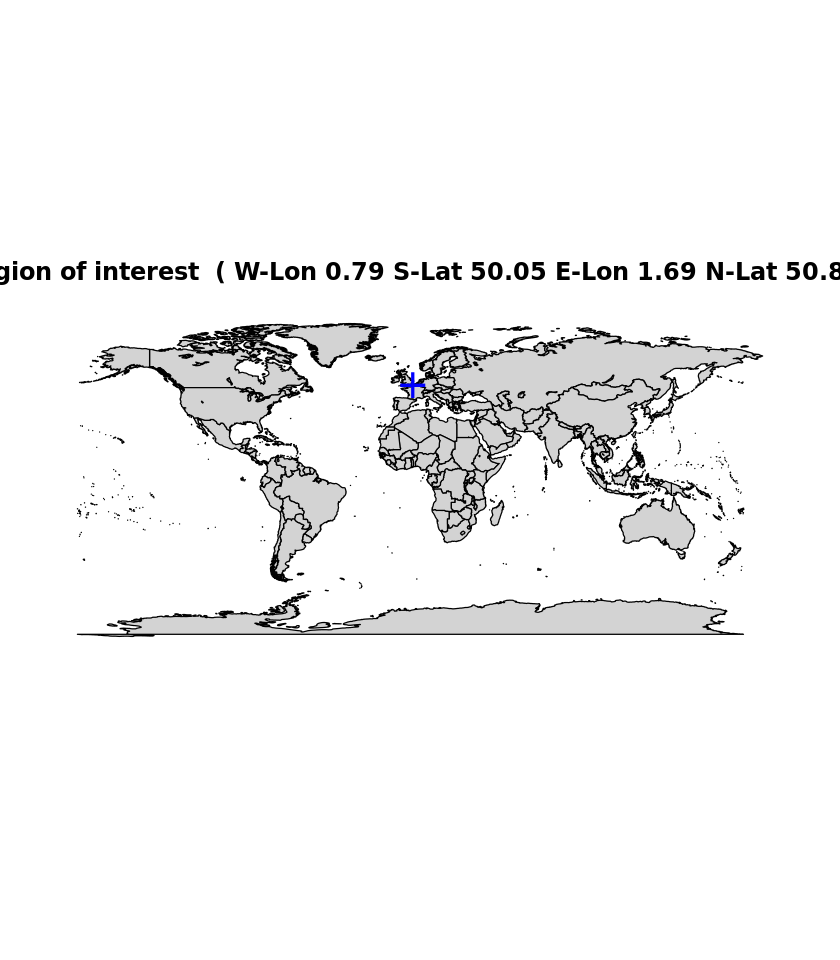

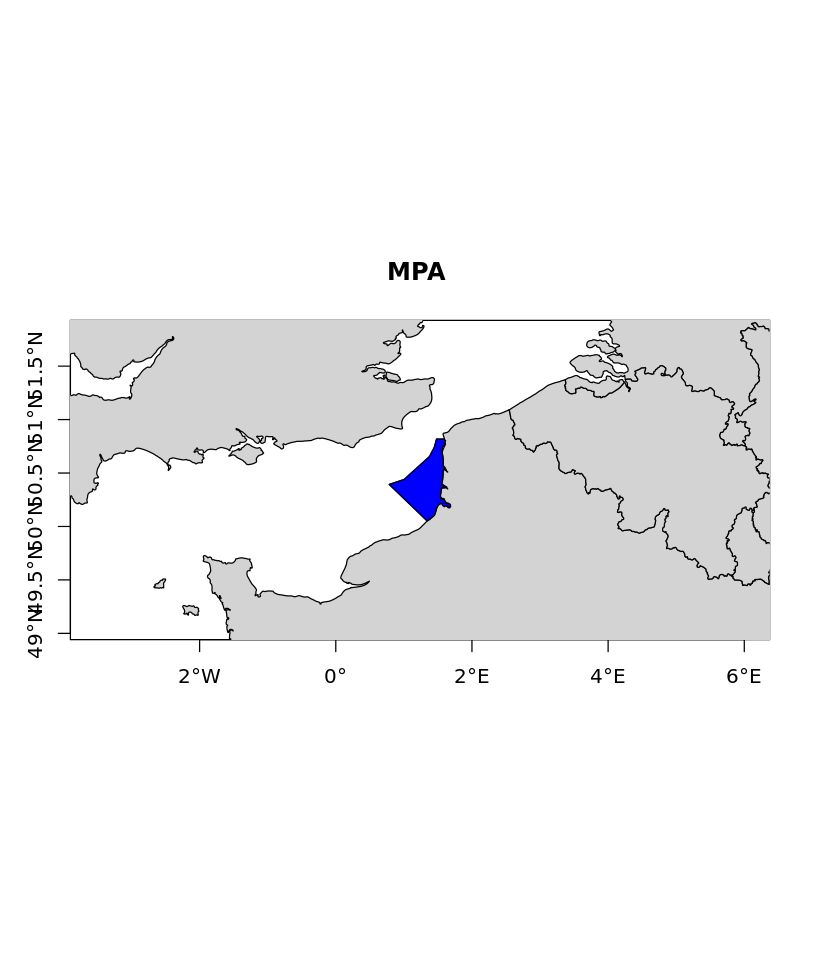

In [3]:
# Localisation at global scale
map("worldHires",col="light grey",fill=T)
points(coordinates(mpa),cex=2,col="blue",pch="+")
title(paste("Region of interest ",
            "( W-Lon",round(xmin,2),
            "S-Lat",round(ymin,2),
            "E-Lon",round(xmax,2),
            "N-Lat",round(ymax,2),")"),cex=.5)

# Localisation at local scale
plot(mpa,xlim=c(xmin-1,xmax+1),ylim=c(ymin-1,ymax+1),axes=T,col="red")
map("worldHires",add=T,col="light grey",fill=T)
plot(mpa,add=T,col="blue")
title(paste("MPA",mpa$ORIG_NAME),cex=.5)

We again extract the bathymetry using the function defined in part 1 of this tutorial.

In [4]:
# Define a function to read in raster data from the EMODnet bathymetry WCS
getbathymetry<-function (name = "emodnet:mean", xmin = 15, xmax = 20.5, ymin = 30, ymax = 32.5){
  bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")
                              
  con <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name,"&crs=EPSG:4326&BBOX=", bbox,
               "&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333", sep = "")
  
  print(con)
  
  stop   
  nomfich <- paste(name, "img.tiff", sep = "_")
  nomfich <- tempfile(nomfich)
  download(con, nomfich, quiet = TRUE, mode = "wb")
  img <- raster(nomfich)
  img <- -1*img # reverse the scale (below sea level = positive)
  img[img == 0] <- NA
  img[img < 0] <- 0
  names(img) <- paste(name)
  return(img)
}

# get the bathymetry data for the MPA
bathy_img <- getbathymetry(name = "emodnet:mean", xmin, xmax, ymin, ymax)
bathy <- as.data.frame(as(bathy_img, "SpatialPixelsDataFrame"))

[1] "https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=0.78521945,50.05172857,1.688691,50.81768059&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333"


# Working with data from EMODnet biology 

## Access polygon data with WFS

Using the EMODnet biology WFS we can get the zooplankton abundances for different grid cells within the MPA (bbox). To calculate statistics of the abundance data over a particular period and a particular season, we can download it as a geoJSON file.

In [5]:
# set the request parameters
reg.name = 36317
spec.name = 'Acartia_spp'
trend_start = 2004
trend_end = 2013
season.code = 1
bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")
type.name='Emodnetbio:OOPS_products_vliz'

# build the WFS URL
url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json"
full_url<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",type.name,"&BBOX=",bbox,sep="")

# get the data as a geoJSON file
library("rjson")
json_data <- fromJSON(file=full_url)
# to display the file
# str(json_data)
# to save
# geojson_write(json_data, file = 'MyJson.geojson') #bogue ?

test<-json_data[['features']]
mean=0 
l<- length(test)
for (i in 1:l){
tests<-test[[l]]
mean<-mean+tests$properties$measurementValue
}
mean_value_season1<-mean/l
mean_value_season1

[1] 0.450216

We can also visualise the extent of the zooplankton abundance grid cell by downloading the data as a zipped shapefile and plotting it on a map.


OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/R-tutorial", layer: "OOPS_products_vlizPolygon"
with 62 features
It has 10 fields


Regions defined for each Polygons



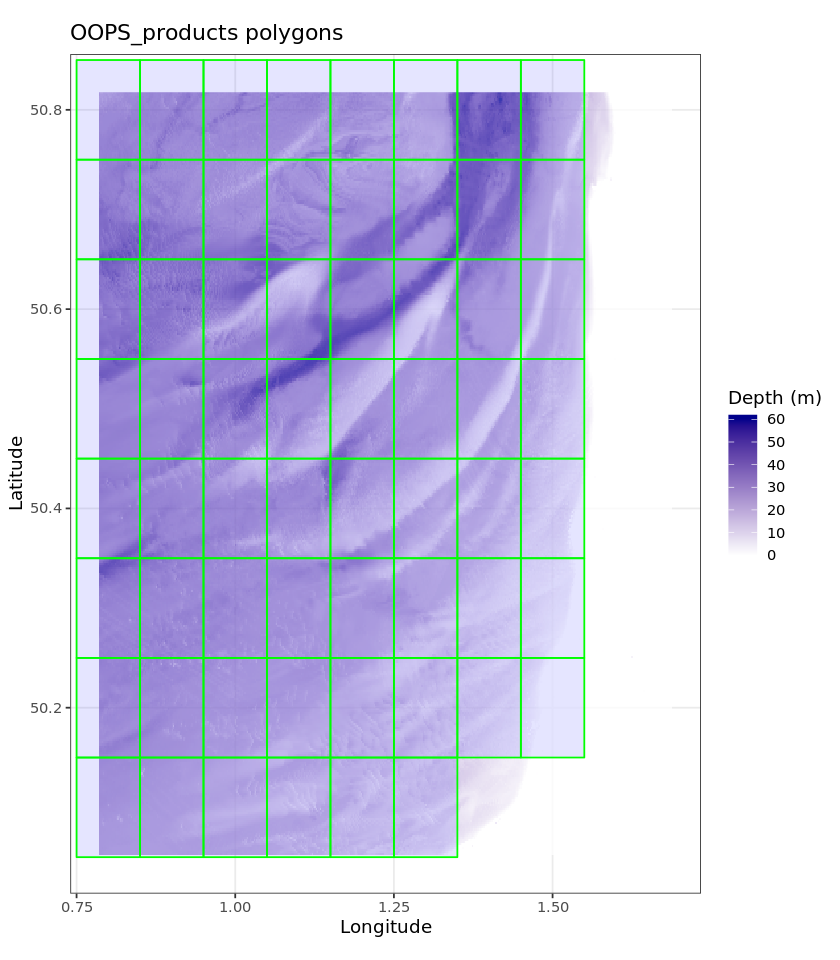

In [6]:
# build the WFS URL
url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=shape-zip"
full_url<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",type.name,"&BBOX=",bbox,sep="")

# get the data as a zipped shapefile
download(full_url, dest="shapefile.zip", mode="wb") 
unzip("shapefile.zip", overwrite = TRUE)
OOPS_products <- readOGR(dsn = ".", layer = "OOPS_products_vlizPolygon")

# plot on a map
map<-ggplot()+
  theme_bw()+
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank())+
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75)+
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)")+
  geom_polygon(data=OOPS_products,aes(x=long,y=lat,group=group, fill="OOPS_products"),colour="green",fill="blue",alpha=.1)+
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
ggtitle("OOPS_products polygons")+xlab("Longitude")+ylab("Latitude")
plot(map)

# export to a shapefile which can then be visualised in e.g. QGIS
writeOGR(OOPS_products,"OOPS_products","OOPS_products_bbox",driver="ESRI Shapefile",overwrite_layer = TRUE)

Alternatively, we can also download the zooplankton abundance grid cell as geoJSON.

[1] "http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json&viewParams=;startYearCollection:2004;mrgid:36317;scientificName:Acartia_spp;season:1&typeName=Emodnetbio:OOPS_products_vliz&BBOX=0.78521945,50.05172857,1.688691,50.81768059"
OGR data source with driver: GeoJSON 
Source: "/tmp/RtmpcMta8H/fileb77efcaf3f", layer: "fileb77efcaf3f"
with 62 features
It has 12 fields, of which 1 list fields


Regions defined for each Polygons



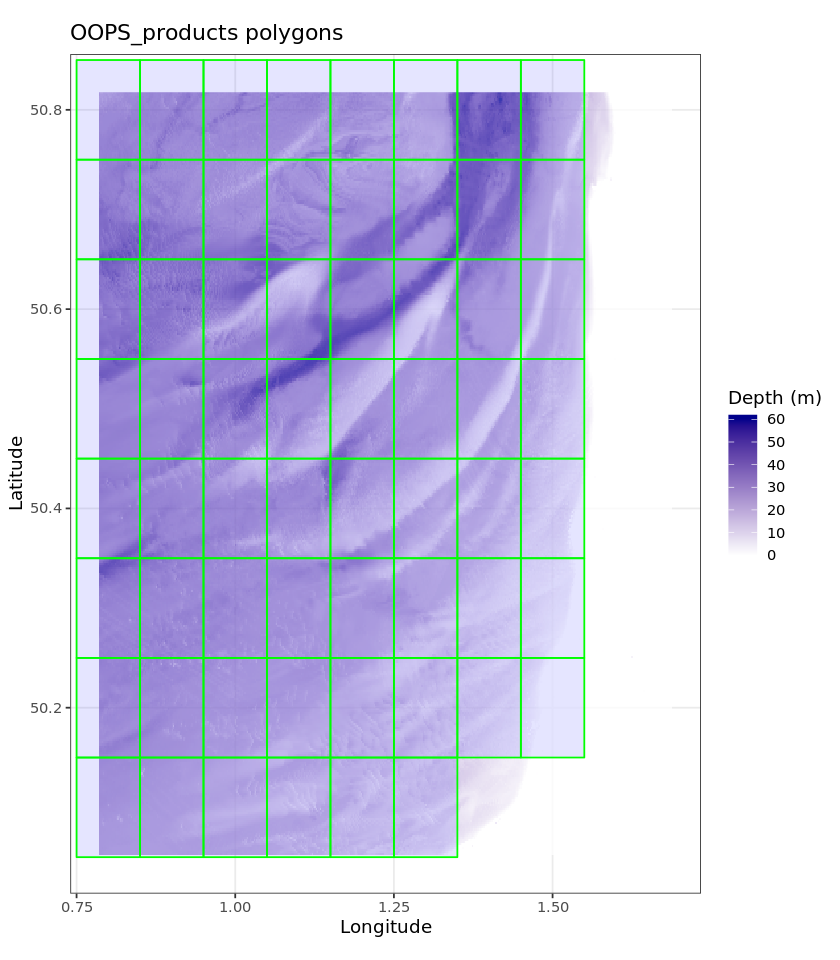

In [7]:
# function to read GeoJSON
getgeojson<-function(name="Emodnetbio:OOPS_products_vliz",xmin=-1,xmax=1,ymin=49,ymax=50){
  reg.name = 36317 #label="Greater North Sea"
  trend_start = 1958 #startDate
  trend_end = 2013 #endDate
  spec.name = 'Acartia_spp'
  trend_start = 2004
  trend_end = 2013
  season.code = 1
  bbox<-paste(xmin,ymin,xmax,ymax,sep=",")
  
  url<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=json"
  con<-paste(url,"&viewParams=;startYearCollection:",trend_start,";mrgid:",reg.name,";scientificName:",spec.name,";season:",season.code,"&typeName=",name,"&BBOX=",bbox,sep="")
  print(con)
  temp <- tempfile()
  download(con,temp)
  ogrInfo(dsn=temp)
  layer<-readOGR(dsn=temp)
  return(layer)
}
OOPS_products<-getgeojson(name="Emodnetbio:OOPS_products_vliz",xmin,xmax,ymin,ymax)

map <- ggplot()+
  theme_bw()+
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_polygon(data=OOPS_products,aes(x=long,y=lat,group=group,fill="OOPS_products"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("OOPS_products polygons")+xlab("Longitude")+ylab("Latitude")

plot(map)

## Access time series data with WFS

Using WFS, we can also access the zooplankton abundance time series as a csv file.


In [8]:
# determine parameters
reg.name = 36317 #label="Greater North Sea"
spec.name = 'Acartia_spp' #species
trend_start = 1958 #startDate
trend_end = 2013 #endDate

# construct WFS url
mainurl<-"http://geo.vliz.be/geoserver/Emodnetbio/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=Emodnetbio:OOPS_summaries&outputFormat=csv&SQL_FILTER=startYearCollection-endYearCollection=0"
fullurl<-paste(mainurl,"ANDscientificName='",spec.name,"'ANDmrgid=",reg.name,sep="")

# get the data
datans <- read.csv(file= fullurl, header=TRUE)

We now analyse the time series seasonality and trends using the `stl()` loess seasonal decomposition function.

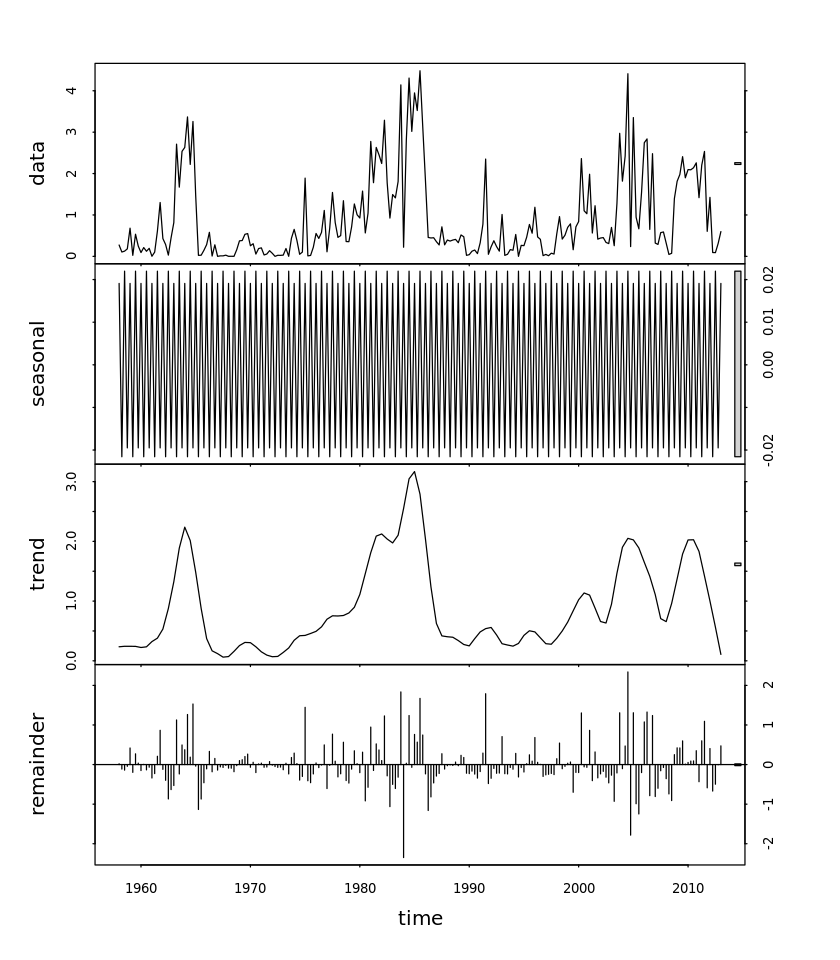

In [9]:
levels(datans$scientificName)[levels(datans$scientificName)=="RatioLS copepods"] <- "Large/Small copepod ratio"
seldata<-datans[with(datans, order(datans$startYearCollection,datans$season)),]
# convert to a time series object
tscf<-ts(data=seldata$avg_ab, start=trend_start, end=trend_end, frequency=4)
# decompose the time series
fitstl<-stl(tscf,s.window="periodic",t.window=15)
plot(fitstl)

# Search for data using EMODnet Catalogue Service

Using the EMODnet Catalogue Service for the Web (CSW), we can query and search collections of metadata for data, services and information objects related to the EMODnet Marine Data. In the example below, we use the `XML` package to send a request to the CSW endpoint, parse the XML response and store it in a dataframe. We use the OGC filter property to select only records whose type is 'dataset'.

In [10]:
# CSW request
con = paste("https://emodnet.ec.europa.eu/geonetwork/emodnet/eng/csw?SERVICE=CSW",
            "REQUEST=GetRecords",
            "VERSION=2.0.2",
            "ELEMENTSETNAME=summary",
            "OUTPUTSCHEMA=http://www.opengis.net/cat/csw/2.0.2",
            "CONSTRAINTLANGUAGE=FILTER",
            "CONSTRAINT_LANGUAGE_VERSION=1.1.0",
            "RESULTTYPE=results",
            "TYPENAMES=csw:Record",
            "maxRecords=300", #limit the output 
            paste0("CONSTRAINT=", #following xml snippet described the filter to be applied, i.e. type=dataset
                   URLencode('<ogc:Filter xmlns:ogc="http://www.opengis.net/ogc">
                                <ogc:PropertyIsEqualTo>
                                    <ogc:PropertyName>dc:type</ogc:PropertyName>
                                    <ogc:Literal>dataset</ogc:Literal>
                                </ogc:PropertyIsEqualTo>
                            </ogc:Filter>')),
            sep="&")
download(con,"cswrequest.xml", mode = "wb")


# get and parse response to a dataframe
response = xmlParse("cswrequest.xml")
response = xmlToList(response)
results = data.frame()
for(record in response$SearchResults[names(response$SearchResults) == "SummaryRecord"]){
  # cast to datafame, negating empty fields
  df = as.data.frame(Filter(Negate(is.null),record),  stringsAsFactors = FALSE)
  # combine multiple subjects into 1 column
  if(sum(grepl("subject",names(df))) > 1){
    df = unite(df,"subject",contains("subject"), sep = ", ", remove = TRUE)
  }
  # combine multiple formats into 1 column
  if(sum(grepl("format",names(df))) > 1){
    df = unite(df,"format",contains("format"), sep = ", ", remove = TRUE) 
  }
  results = bind_rows(results,df)
}

Now that we have all the records stored in a dataframe, we can perform detailed queries.

In [11]:
# look for Records with keyword 'Habitat'
results %>%
  filter(grepl("Habitat",results$subject)) %>%
  # limit printing length of abstract
  mutate(abstract = paste(substring(abstract,0,80),"...")) %>%
  knitr::kable(floating.environment="sidewaystable") %>%
  kable_styling(bootstrap_options = c("condensed","striped","hover")) %>%
  as.character() %>% display_html()

identifier,title,type,subject,format,abstract,modified,relation
8f8a9aa2-528b-4494-ab88-74633dfcf446,EMODnet Human Activities: Protected Areas,dataset,"Area management/restriction/regulation zones and reporting units, Land cover, Protected sites, Habitats and biotopes, protected area, natural area, natural areas protection, environment",unknown,The dataset on marine and coastal protected areas in the EU was created in 2014 ...,2016-04-13,NA
47489848-e54d-4bfa-bbec-c5516273b9f7,Caratterizzazione bio-ecologica e bionomica del Parco Marino Sommerso di Gaiola,dataset,"Habitats and biotopes, Map Files, biota, environment",Shapefile,The research work had the aim to obtain a first quantitative information for the ...,NA,NA
bcd93384-72f8-4a7e-a1db-903b59247492,Seabed Habitat (EUNIS) - FR9301998 'Baie de la Ciotat' (Cartham) - FR003034,dataset,"Habitats and biotopes, Natura 2000, Parc naturel marin, Intertidal, Subtidal, Circalittoral, Biocénoses, Observation terrain, Transects plongeur audio, Plongées ponctuelles, Sonar, Bathymétrie, Habitat, Cartographie, France, Méditerranée, Bouches-du-Rhône, Ciotat, benthos, oceans",NA,Seabed habitat map (EUNIS classification system) performed by Andromede Oceanolo ...,NA,NA
7edf2f11-b203-4eb5-92e8-e92478e3dc7c,DK003046_HabitatsDirective_DEF,dataset,"Habitats and biotopes, Downloadable Data, Downloadable Data, biota, geoscientificInformation, oceans",Shapefile,The substrate and nature type mapping was carried out for the Danish Nature Agen ...,NA,NA
7bdbf389-3bf7-46db-97c7-f2ee0093995f,A74-Littoral Biotope Survey and Condition Assessment of the Tamar Tavy & St John's Lake SSSIs 2010,NA,"Eastern Channel, Marine habitat mapping, EUNIS, Habitats and biotopes, Oceanographic geographical features, environment",ESRI Shapefile,A Natural England commissioned verification survey. Littoral biotope survey and ...,NA,NA
0d6bfc21-a567-428f-850b-ea8237c4c484,LongBank_HD_DEF,dataset,"Habitats and biotopes, Downloadable Data, biota, environment",Shapefile,This file shows the distribution of the Annex 1 sandwaves in the Long Bank SAC. ...,NA,NA
6804f273-2fb1-409d-832d-049d1bdac152,Littoral and infralittoral biogenic reefs associated to Crassostrea angulata along the southatlantic spanish coast,NA,"Marine Strategy Framework Directive, Marine habitat mapping, Habitats and biotopes, environment",Shapefile,Spatial distribution along the southatlantic spanish coast of the habitat: Litto ...,NA,NA
6f78f452-8aa2-4e3f-933b-781b9f88533b,Caratterizzazione bio-ecologica e bionomica del Parco Marino Sommerso di Baia (Fanerogame),dataset,"Habitats and biotopes, Habitats and biotopes, biota, environment",Shapefile,The research work had the aim to obtain a first quantitative information for the ...,NA,NA
42ac3bd5-9135-4b07-9423-09f485624f5b,Marine habitat mapping within the GR1270010 Natura site (Akrotirio Pyrgos - Ormos Kypsas - Malamo),NA,"Marine habitat mapping, Habitats and biotopes, Protected sites, environment",Shapefile,The description and mapping of marine habitat types according to Annex I of Dire ...,NA,NA
7d86e10b-104e-4af7-b6c6-87e77784b3af,DK003002_HabitatsDirective_DEF,dataset,"Habitats and biotopes, Downloadable Data, Downloadable Data, biota, geoscientificInformation, oceans",Shapefile,The Ministry of the Environment requested in 2011 the Consortium GEUS and Orbico ...,NA,NA


In [12]:
# look for Records with keyword 'substrate'
results %>%
  filter(grepl("substrate",results$subject)) %>%
  mutate(abstract = paste(substring(abstract,0,80),"...")) %>%  # limit printing length of abstract
  knitr::kable(floating.environment="sidewaystable") %>%
  kable_styling(bootstrap_options = c("condensed","striped","hover")) %>%
  as.character() %>% display_html()

identifier,title,type,subject,format,abstract,modified,relation
da029dbc-a4de-45c7-9666-ae7e35d93af4,Celtic Sea Nearshore Habitats,dataset,"habitat, biotope, sea, sea bed, sediment, rock, classification, Habitats and biotopes, substrate, oceans, geoscientificInformation, environment",Esri shapefile,Multibeam echosounder data and seabed sampling data acquired during the INFOMAR ...,2013-07-02,NA


### [>> Back to index](./index.ipynb)

-----------------------------------------------------------------------------------------------------------
<center> Provided by EMODnet. See our <a href=https://emodnet.ec.europa.eu/en/terms-use> terms of use </a></center>
<center><a href="https://emodnet.ec.europa.eu/"><img style="float: None" style="border-width:0" src="https://emodnet.ec.europa.eu/sites/emodnet.ec.europa.eu/files/public/logo_2x_1.png" /></a>
</center>